In [1]:
import pandas as pd

import numpy as np
import os, sys

# pvlib imports
import pvlib

from pvlib.pvsystem import PVSystem

from pvlib.location import Location

from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

from timeseries_functions import timeseries_plotter, timesteplen_calculator, cleaner_per_day
from dtw import *

import plotly.express as px
import seaborn as sns
import h5py

ModuleNotFoundError: No module named 'pvlib'

# Data Imports

In [5]:
timesteplen = 30 # in seconds
limit = int((60/timesteplen) * 15)

target_timesteplen = 5 #minutes

## Load

In [6]:
filename = "../../Data/Load/2018_data_1min.hdf5"

f = h5py.File(filename)

group_no_pv = f["NO_PV"]

dfs = {}

for key in group_no_pv.keys():
    
    table = group_no_pv[key]["HOUSEHOLD"]

    table = table["table"][:]
    
    df = pd.DataFrame(table).dropna().set_index("index")[["P_TOT"]]
    df.index = pd.to_datetime(df.index, unit = "s")

    dfs[key] = df

df_load = pd.concat(list(dfs.values()), axis=1)



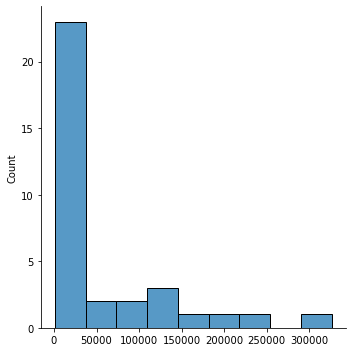

In [7]:
df_load.columns = list(dfs.keys())
sns.displot(df_load.isna().sum().sort_values())

In [11]:
df_load_1 = df_cleaner_per_day(df_load, 4, 0.99)

df_load_2 = df_load_1.drop(["SFH24"], axis=1)

4 days were removed because of too many missing measurements per day
4879 measurements were removed because of too many missing measurements per day
4 days were removed because of too many missing measurements per day
4879 measurements were removed because of too many missing measurements per day
7 days were removed because of too many missing measurements per day
9199 measurements were removed because of too many missing measurements per day
7 days were removed because of too many missing measurements per day
9199 measurements were removed because of too many missing measurements per day
8 days were removed because of too many missing measurements per day
10639 measurements were removed because of too many missing measurements per day
28 days were removed because of too many missing measurements per day
39439 measurements were removed because of too many missing measurements per day
9 days were removed because of too many missing measurements per day
12079 measurements were removed be

In [13]:

df_load = df_load_2.resample(str(target_timesteplen) + "T").mean()

In [16]:
os.getcwd()

'/Users/nikolaushouben/Library/Mobile Documents/com~apple~CloudDocs/PhD_Icloud/PhD_Research/Paper_2_Collaborative Forecasting/Code/Collaborative_PV_Forecasting'

In [18]:
df_load.to_csv("../../Input_Data/UTC_electric_load_DE.csv")

In [54]:
df_load_18 = df_load[:"2019"]
df_load_19 = df_load["2018":]

df_load_18.index = df_load_18.index.map(lambda t: t.replace(year = 2015))
df_load_19.index = df_load_19.index.map(lambda t: t.replace(year = 2016))

df_load = pd.concat([df_load_18, df_load_19], axis = 0)

## PV

In [3]:
df_meteo = pd.read_csv("../../Data/Meteo/GHI_DNI_DHI.csv", index_col=1, parse_dates=True)
df_meteo = df_meteo.iloc[:,2:]
print(df_meteo.columns)
df_meteo.columns = ["dhi", "dni", "ghi"]
df_meteo = df_meteo.resample("5T").mean()
df_meteo = df_meteo.tz_localize(None)


Index(['Dhi', 'Dni', 'Ghi'], dtype='object')


In [4]:
df_system_power = pd.read_csv("../../Data/System/2015-2016 50 PV systems 30s TU WIEN.csv", index_col=0, parse_dates=True)
df_system_power.index = pd.to_datetime(df_system_power.index).tz_localize(None)
df_system_power.columns = [column.replace("s","") for column in df_system_power.columns]
df_system_power_agg = pd.DataFrame(df_system_power.sum(axis=1))
df_system_power_agg.columns = ["pv_output"]

In [5]:
selected_systems = list(df_system_power.isna().sum().sort_values()[:34].index)
df_system_power = df_system_power[selected_systems]

# Data Cleaning

## PV

In [10]:
def cleaner_per_day_pv(power_series, nan_threshold, logs = True):

    '''Remove days from pandas time series, if more than nan_threshold are nans.'''
    dates = []
    n_rows_total_before = power_series.shape[0]
    for day, data in power_series.groupby(power_series.index.date):
        n_rows = data.shape[0]
        nans = np.isnan(data.values).sum()
        ratio_of_nans = nans / n_rows
        if ratio_of_nans > nan_threshold:  # ratio threshold empiricallydf determined
                dates.append(day)

    dates = list(set(dates))  # unique days
    mask1 = ~np.in1d(power_series.index.date, dates)
    power_series_cleaned = power_series.loc[mask1]
    n_rows_total_after = power_series_cleaned.shape[0]

    # log messages
    if logs == True:
        print(
            "{0} days were removed because of too many missing measurements per day".format(
                len(dates)
            )
        )
        print(
            "{0} measurements were removed because of too many missing measurements per day".format(
                n_rows_total_before - n_rows_total_after
            )
        )

    return power_series_cleaned


def df_cleaner_per_day(df, interpolation_limit, treshold_nan, logs=True, interpolation_method:str= "linear"):

    df = df.interpolate(method = interpolation_method, axis = 0, limit = interpolation_limit)

    cleaned_columns = []
    timesteplen_ = timesteplen_calculator(df)
    new_index = pd.date_range(df.index[0], df.index[-1], freq= str(timesteplen_) + "s")

    for column in df:
        cleaned_col = cleaner_per_day_pv(df[column], treshold_nan,logs=logs)
        cleaned_col.reindex(new_index, fill_value = np.nan)
        cleaned_col.name = column
        cleaned_columns.append(cleaned_col)

    df = pd.concat(cleaned_columns, axis = 1)
    df.dropna(thresh = df.shape[1] - 1, inplace=True)
    return df

def timesteplen_calculator(df):
    """Infers the interval of a timeseries"""
    timesteplens = []
    for i in range((int(df.shape[0] * 0.1))):
        diff = df.index[i + 1] - df.index[i]
        timesteplen = int(diff.seconds)
        timesteplens.append(timesteplen)
    timesteplen_final = int(round(np.array(timesteplens).mean()))

    return timesteplen_final

In [7]:
df_system_power_1 = df_cleaner_per_day(df_system_power, limit, 0.1, logs=False)

In [ ]:
fig = px.line(df_system_power_1.iloc[:,:4])
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [8]:
os.getcwd()

'/Users/nikolaushouben/Library/Mobile Documents/com~apple~CloudDocs/PhD_Icloud/PhD_Research/Paper_2_Collaborative Forecasting/Code/Collaborative_PV_Forecasting'

In [9]:
df_system_power_1.to_csv("../../Input_Data/PV_System_Power.csv")

## Load

7 days were removed because of too many missing measurements per day
614 measurements were removed because of too many missing measurements per day
7 days were removed because of too many missing measurements per day
614 measurements were removed because of too many missing measurements per day
13 days were removed because of too many missing measurements per day
1190 measurements were removed because of too many missing measurements per day
13 days were removed because of too many missing measurements per day
1190 measurements were removed because of too many missing measurements per day
15 days were removed because of too many missing measurements per day
1382 measurements were removed because of too many missing measurements per day
53 days were removed because of too many missing measurements per day
5030 measurements were removed because of too many missing measurements per day
17 days were removed because of too many missing measurements per day
1574 measurements were removed bec

# Merging

In [103]:
df_load_3 = df_load_2

df_load_3.columns = df_system_power_7.columns[:-1]

df_load_3

,281,195,152,207,154,175,384,389,444,188,...,194,370,329,192,151,523,353,383,499,395
index,,,,,,,,,,,,,,,,,,,,,
2015-12-18 12:45:00,504.489334,1200.822777,118.776889,389.185332,119.924778,485.079889,105.401000,154.904445,158.457333,191.763666,...,252.600444,287.551777,178.767223,378.840111,760.520020,198.774557,55.293889,211.541112,651.133331,176.738000
2015-12-18 13:00:00,513.394109,268.782555,134.065778,404.748667,130.686445,560.243448,130.231777,154.940223,119.873333,257.882445,...,237.564112,317.258779,100.084000,338.258111,760.520020,201.395778,650.134002,192.512000,674.546329,326.865445
2015-12-18 13:15:00,407.924666,673.291671,155.531333,351.221002,126.144333,508.513221,118.756000,176.219000,216.100555,133.775444,...,192.695001,264.221000,98.723222,335.638776,760.520020,200.938889,1294.847226,159.437111,664.245556,254.509112
2015-12-18 13:30:00,661.988663,1358.784108,245.962667,412.359999,107.973666,450.497000,122.447556,185.431333,238.043112,113.090445,...,196.450333,338.671334,172.312556,334.038002,760.520020,256.473556,137.655222,222.699112,321.282446,222.726222
2015-12-18 13:45:00,2349.629338,1183.353333,220.065333,380.728669,96.155889,1125.089551,122.200000,178.777554,199.073889,138.044111,...,205.327444,1076.678007,237.950001,396.368998,760.520020,329.077556,58.013222,205.461666,145.828223,210.704444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 22:45:00,562.455109,461.818000,112.824889,1344.613779,222.412445,715.366333,168.126444,512.521222,574.406002,397.240555,...,722.513111,758.959110,113.439666,481.994999,113.962778,612.551665,197.430000,1142.843886,1251.119557,471.846222
2016-12-31 23:00:00,675.809998,528.409973,104.139999,1089.400024,228.050003,682.729980,173.139999,405.760010,509.470001,447.070007,...,1579.349976,665.960022,155.029999,532.179993,216.089996,421.420013,201.960007,1147.339966,2288.209961,537.150024
2016-12-31 23:15:00,675.809998,528.409973,104.139999,1089.400024,228.050003,682.729980,173.139999,405.760010,509.470001,447.070007,...,1579.349976,665.960022,155.029999,532.179993,216.089996,421.420013,201.960007,1147.339966,2288.209961,537.150024


In [116]:
first_index

Timestamp('2015-01-01 00:00:00')

In [118]:
new_index = pd.date_range(first_index, last_index, freq= str(target_timesteplen)+ "T")

In [119]:
df_system_power_8 = df_system_power_7.reindex(new_index)

df_load_4 = df_load_3.reindex(new_index)

In [120]:
df_load_4

,281,195,152,207,154,175,384,389,444,188,...,194,370,329,192,151,523,353,383,499,395
2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-29 22:45:00,572.053331,140.445888,168.937444,600.522443,290.911888,329.685221,129.987111,276.400000,774.550891,210.526999,...,213.752112,535.617332,174.902222,562.727332,511.629444,517.730110,409.282665,211.903890,335.061110,244.621000
2016-12-29 23:00:00,639.192668,206.565112,137.323666,621.172222,245.996111,249.350555,139.685222,224.846112,801.264447,166.011445,...,220.325999,445.180556,135.898556,447.157888,233.771223,535.575777,513.988333,136.286333,227.627001,213.642999
2016-12-29 23:15:00,594.270667,139.439000,213.512222,641.313555,160.555445,276.162444,309.286221,180.408445,781.666667,209.375667,...,206.928111,494.882111,151.825222,302.180556,123.856111,649.261002,214.307334,120.944889,180.723999,144.966222
2016-12-29 23:30:00,541.581774,190.649555,246.161333,612.103669,120.836111,239.732111,107.471445,166.355000,902.934224,196.820445,...,204.414889,339.158001,193.859888,304.620998,139.188111,554.676889,188.346001,103.760889,246.930777,69.303667


In [123]:
for column in df_load_4:
    df_load_4[column] -= df_system_power_8[column]

In [129]:

net_loads = []
for column in df_load_3:
    net_load = pd.merge(df_load_3[column],(-1)*df_system_power_7[column], left_index= True, right_index= True)
    #print(net_load)
    net_load = net_load.sum(axis = 1)
    net_load.name = column
    #print(net_load)
    net_loads.append(net_load)

df_net_load = pd.concat(net_loads, axis = 1)

In [ ]:

def physical_profile(row):
    index, latitude, longitude, tilt, azimuth, capacity = row

    temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

    location = Location(latitude=latitude, longitude=longitude)

    pvwatts_system = PVSystem(surface_tilt= tilt , surface_azimuth=azimuth,
        module_parameters={'pdc0': capacity, 'gamma_pdc': -0.004},
        inverter_parameters={'pdc0': capacity},
        temperature_model_parameters=temperature_model_parameters)
    
    mc = ModelChain(pvwatts_system, location, aoi_model='physical', spectral_model='no_loss')
    mc.run_model(df_meteo)
    results = mc.results.ac

    df_results = pd.Series(results)
    df_results.index = df_results.index.tz_localize(None)
    df_results.index.name = "timestamp"

    return df_results